In [3]:
import hytools as ht
import matplotlib.pyplot as plt
import numpy as np



In [5]:
envi = ht.HyTools()
envi.read_file("output_file",'envi')

In [7]:
envi.get_pixels(500,500)

memmap([230.89001118, 265.29973664, 227.50122958, 453.15689901,
        289.9373611 , 150.14576218])

In [74]:
original[0]

array([-9998.99999999, -9999.        , -9999.        , -9999.        ,
       -9999.        , -9998.99935073])

In [23]:
envi.wavelengths

array([ 480.,  560.,  655.,  865., 1610., 2200.])

In [54]:
import numpy as np
np.arange(11, 17, 0.5).tolist()

[11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0, 16.5]

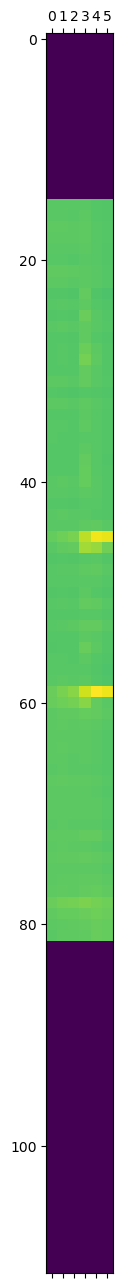

In [69]:
plt.matshow(original)

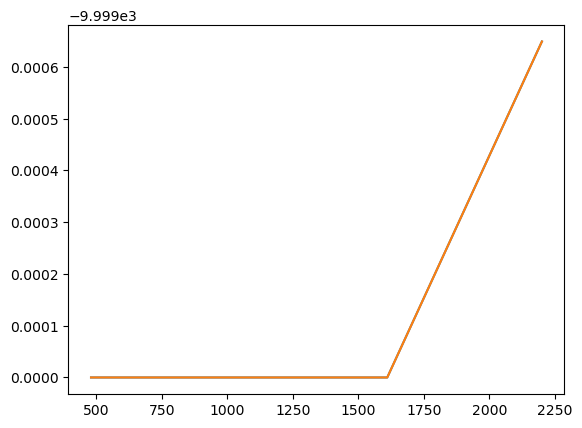

In [73]:
#plt.plot(envi.wavelengths,original[0])
rowrange = np.arange(0, envi.columns, 10).tolist()
colrange = np.arange(0, envi.columns, 10).tolist()

original = envi.get_pixels(rowrange, colrange)

original
plt.plot(envi.wavelengths,original[5])
plt.plot(envi.wavelengths,original[10])

#plt.ylim(0,.6)